In [ ]:
# Parameters
num_periods = 10
x = 1

In [1]:
from input_properties import Mine_properties, concentration_func
from mining_data import mining_data
from Mine import Mine
from Time import Time
from Scheduler import Scheduler
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
import requests
import json

# Ollama server URL
OLLAMA_URL = "http://localhost:11434/api/chat"
MODEL = "gpt-oss"

# Function to send messages to Ollama
def ask_ollama(messages, stream=False):
    payload = {
        "model": MODEL,
        "messages": messages,
        "stream": stream
    }
    resp = requests.post(OLLAMA_URL, json=payload)
    return resp.json()

# Conversation memory
conversation = []
gpt_connversation = []

In [ ]:
# Initialize mining data
# x=3
state = mining_data((x, 2, 1))
arr, block_properties, HnD = state.build(concentration_func=concentration_func)

In [4]:
# # Create mine instance
# import random
# random.seed(42)
# print(arr.flatten())
# mine_tonnage_list = []
# for i in range(1,arr.flatten().shape[0]+1):
#     random_value = random.randint(50, 90)
#     mine_tonnage_list.append(random_value)

# Mine_properties['block_tonnage'] = mine_tonnage_list
mining_instance = Mine(
    arr,
    block_properties,
    HnD,
    num_periods,
    Mine_properties
)

In [5]:
time_func = Time()
choice = 'greedy'  # or 'minimum'
scheduler = Scheduler(mining_instance, time_func)

In [6]:
action_list = scheduler.possible_actions()
period = scheduler.time_func.period()
scheduler.update_action(action_list,action='initialize')

In [7]:
system_prompt = '''
You are a Mine Scheduler. At each time period, First I will give you the state of the mine. It is a 3D array where each row represents a layer of the mine. The array elements are structured as follows:(block number, ore concentration, ton of block to extract,ton of block to process). Then I will provide you with a list of possible actions which are formatted as follows: (choice, block_number, ton_present, per unit change in NPV if selected). If choice=1, it will do extraction if choice=2 it will do processing. If processing you will receive revenue and if extraction you will have cost. Your task is to chose one action in following format: (choice,block_number,amount_you_want_to_be_operated_on) which is optimal based on maximizing the Net Present Value (NPV) over a specified number of periods. Then I will give you the updated state after your action. You will repeat this process until all periods are completed. Keep in mind the following constraints:
1. After full extraction of block you will see that it can also be processed in the next action.
2. Extraction can cost but processing generates revenue.
3. Extraction cannot be 0 amount if possible.
4. The period will change when the limit exceeds, will know as works are being done.
Always respond in JSON format not in plain text. The format is as follow:
{
  "choice": [1/2],
  "block_number": (int),
  "amount": (int)
}
Always follow the format. Only give this nothing else needed.
'''
conversation.append({"role": "system", "content": system_prompt})
gpt_connversation.append({"role": "system", "content": system_prompt})

In [8]:
scheduler.mine.mine_state()

[[[(1, 0.61, 50, 30), (2, 0.6, 50, 30), (3, 0.58, 50, 28), (4, 0.67, 50, 33)],
  [(5, 0.66, 50, 33), (6, 0.63, 50, 31), (7, 0.72, 50, 36), (8, 0.71, 50, 35)],
  [(9, 0.68, 50, 34),
   (10, 0.75, 50, 37),
   (11, 0.74, 50, 37),
   (12, 0.71, 50, 35)]],
 [[(13, 0.53, 50, 26),
   (14, 0.55, 50, 27),
   (15, 0.51, 50, 25),
   (16, 0.69, 50, 34)],
  [(17, 0.71, 50, 35),
   (18, 0.66, 50, 33),
   (19, 0.81, 50, 40),
   (20, 0.83, 50, 41)],
  [(21, 0.77, 50, 38),
   (22, 0.85, 50, 42),
   (23, 0.88, 50, 44),
   (24, 0.81, 50, 40)]],
 [[(25, 0.0, 50, 0), (26, 0.0, 50, 0), (27, 0.0, 50, 0), (28, 0.0, 50, 0)],
  [(29, 0.0, 50, 0), (30, 0.0, 50, 0), (31, 0.0, 50, 0), (32, 1.0, 50, 50)],
  [(33, 1.0, 50, 50), (34, 0.0, 50, 0), (35, 0.0, 50, 0), (36, 0.0, 50, 0)]]]

In [9]:
prompt = f"Time_period-{period}: Here is mine state: {scheduler.mine.mine_state()}, Here are the possible actions: {scheduler.possible_actions()}"
# print(prompt)
conversation.append({"role": "user", "content": prompt})
gpt_connversation.append({"role": "user", "content": prompt})

response = ask_ollama(gpt_connversation)

conversation.append({"role": "Scheduler", "content": response['message']})

In [10]:
# response['message']['content']

In [11]:
while period <= num_periods:
    assistant_msg = response['message']['content']
    # Remove ```json and ``` if present
    clean = assistant_msg.strip().strip("`").replace("```json", "").replace("```", "").replace("json","").strip()
    # print("Cleaned Assistant Message:", clean)
    try:
        parsed = json.loads(clean)
    except json.JSONDecodeError as e:
        print("JSON decoding error:", e)
        print("Original Assistant Message:", assistant_msg)
        response = ask_ollama(gpt_connversation)
        continue
    # parsed = json.loads(assistant_msg)
    try:
        mapping = {
            "extract": 1,
            "extraction":1,
            "process": 2,
            "1": 1,
            "2": 2
        }
        raw_choice = parsed["choice"]

        if isinstance(raw_choice, int) and raw_choice in (1, 2):
            choice = raw_choice
        elif isinstance(raw_choice, str) and raw_choice.strip().lower() in mapping:
            choice = mapping[raw_choice.strip().lower()]
        else:
            raise ValueError("Invalid choice input.")
        
        raw_block = parsed.get("block_number", parsed.get("block"))
        if raw_block is None:
            raise KeyError("Neither 'block_number' nor 'block' found.")

        block_number = int(raw_block)
        
        amount = int(parsed['amount'])

    except KeyError as e:
        print("Key error:", e)
        print("Parsed JSON:", parsed)
        response = ask_ollama(gpt_connversation)
        continue
    except TypeError as e:
        print("Type error:", e)
        print("Parsed JSON:", parsed)
        response = ask_ollama(gpt_connversation)
        continue
    except ValueError as e:
        print("Value error:", e)
        print("Parsed JSON:", parsed)
        response = ask_ollama(gpt_connversation)
        continue
    
    print("Choice:", choice)
    print("Block Number:", block_number)
    print("Amount:", amount)
    action = (choice,block_number,amount)
    listed = scheduler.possible_actions()
    match_found = any(
                    c == action[0] and b == action[1] and action[2] <= cap 
                    for c, b, cap, _ in listed
                )

    if not match_found:
        response = ask_ollama(gpt_connversation)
        continue

    action, pv = scheduler.choosen_action(action)
    scheduler.update_action(action,present_value=pv)
    scheduler.action(action)
    if len(scheduler.possible_actions()) == 0:
        scheduler.time_tick()
        if len(scheduler.possible_actions()) == 0:
            print("No more possible actions available. Exiting loop.")
            break
        else:
            scheduler.update_action(scheduler.possible_actions(),action='initialize')
            
    prompt = f"choice was: {choice}, block_number was: {block_number}, amount was: {amount}. Current NPV is: {scheduler.mine.npv}, Time_period-{period}: Here is mine state: {scheduler.mine.mine_state()}, Here are the updated possible actions: {scheduler.possible_actions()}. Choose from possible actions on in this format('choice': [1/2],  'block_number':(int), 'amount': (int))"
    
    conversation.append({"role": "user", "content": prompt})
    gpt_connversation.append({"role": "user", "content": prompt})
    
    response = ask_ollama(gpt_connversation)
    # print(prompt)
    print("Scheduler Response:", response)
    conversation.append({"role": "Scheduler", "content": response['message']})
    period = scheduler.time_func.period()

Choice: 1
Block Number: 12
Amount: 50
Scheduler Response: {'model': 'gpt-oss', 'created_at': '2025-12-15T22:22:43.193726183Z', 'message': {'role': 'assistant', 'content': '{\n  "choice": 2,\n  "block_number": 12,\n  "amount": 35\n}', 'thinking': 'We need to choose optimal action. The state: block 12 has already 0.0 ton left to extract, but has processing ton 35 (ton to process?). The actions list includes extraction actions for block 1-11 (20 ton each) cost -9.09 per ton? Actually cost -9.09 per unit change in NPV if selected. For block 12, action (2,12,35,90.91) is processing block 12, 35 ton to process with revenue 90.91 per unit? The per unit change is 90.91 meaning positive NPV per ton processed. So processing block 12 gives huge benefit. So we should choose (2,12,35). But note extraction cannot be 0 amount if possible? But we can process.\n\nThus output JSON: choice: 2, block_number: 12, amount: 35.'}, 'done': True, 'done_reason': 'stop', 'total_duration': 25094698155, 'load_durat

In [12]:
scheduler.possible_actions()

[]

In [13]:
for key, row in scheduler.actions_taken.items():
    print(f"{key}: {row['actions_taken']}")

1: [(1, 12, 50), (2, 12, 35), (1, 10, 20)]
2: [(1, 10, 30), (1, 1, 40), (2, 10, 37)]
3: [(1, 1, 10), (1, 2, 50), (2, 1, 30), (1, 3, 10), (2, 2, 10)]
4: [(2, 2, 20), (1, 3, 40), (2, 3, 20), (1, 6, 30)]
5: [(2, 3, 8), (1, 6, 20), (2, 6, 31), (1, 4, 50), (2, 4, 1)]
6: [(2, 4, 32), (1, 11, 50), (2, 11, 8), (1, 5, 20)]
7: [(2, 11, 29), (1, 5, 30), (2, 5, 11), (1, 7, 40)]
8: [(2, 5, 22), (1, 7, 10), (2, 7, 18), (1, 8, 50), (1, 23, 10)]
9: [(2, 8, 35), (2, 7, 5), (1, 23, 40), (1, 20, 30)]
10: [(2, 7, 13), (2, 23, 27), (1, 20, 20), (1, 9, 50)]
11: [(2, 9, 34), (2, 20, 6), (1, 22, 50), (1, 13, 20)]
12: [(2, 22, 40), (1, 13, 30), (1, 19, 40)]
13: [(2, 13, 26), (2, 20, 14), (1, 19, 10), (1, 14, 50), (1, 24, 10)]
14: [(2, 19, 40), (1, 24, 40), (1, 21, 30)]
15: [(2, 24, 40), (1, 21, 20), (1, 15, 1), (1, 17, 49)]
16: [(2, 21, 38), (2, 14, 2), (1, 16, 50), (1, 17, 1), (1, 15, 19)]
17: [(2, 17, 35), (2, 23, 5), (1, 15, 30), (1, 32, 40)]
18: [(2, 16, 34), (2, 23, 6), (1, 32, 10), (1, 18, 50), (1, 33, 1

In [14]:
now = pd.Timestamp.now()
formatted_now = now.strftime("%Y%m%d_%H%M%S")
data = []

In [15]:
len(arr.flatten())

36

In [ ]:
with open(f"/home/mustavi/mining/00blocks_ipynb/results/{len(arr.flatten())}_schedular_{formatted_now}_mine_state.txt", "w") as f:
    for msg in conversation:
        f.write(f"{msg['role'].upper()}:\n{msg['content']}\n\n")

Period: 1 Scheduler NPV: 2545.45
Period: 2 Scheduler NPV: 5024.79
Period: 3 Scheduler NPV: 7504.120000000001
Period: 4 Scheduler NPV: 9758.070000000003
Period: 5 Scheduler NPV: 11807.120000000004
Period: 6 Scheduler NPV: 13669.890000000005
Period: 7 Scheduler NPV: 15363.310000000003
Period: 8 Scheduler NPV: 16902.790000000005
Period: 9 Scheduler NPV: 18302.310000000005
Period: 10 Scheduler NPV: 19574.610000000004
Period: 11 Scheduler NPV: 20731.240000000005
Period: 12 Scheduler NPV: 21782.720000000005
Period: 13 Scheduler NPV: 22738.61
Period: 14 Scheduler NPV: 23607.61
Period: 15 Scheduler NPV: 24397.61
Period: 16 Scheduler NPV: 25115.79
Period: 17 Scheduler NPV: 25768.68
Period: 18 Scheduler NPV: 26362.209999999995
Period: 19 Scheduler NPV: 26901.789999999994
Period: 20 Scheduler NPV: 27392.289999999983


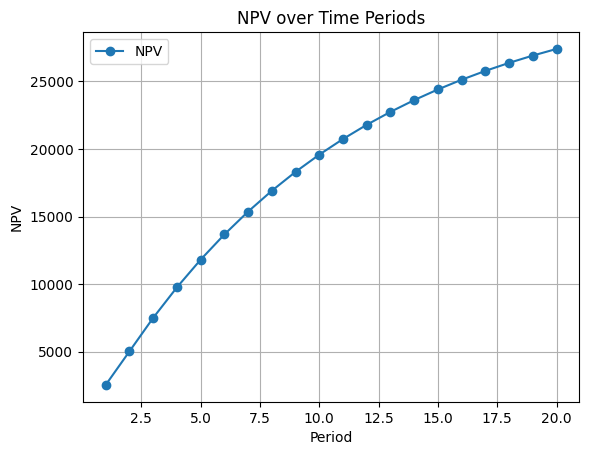

In [ ]:
for key, val in scheduler.actions_taken.items():
    time_period = key
    print(f"Period: {time_period}",end=' ')
    npv = val['npv'][-1]
    print(f"Scheduler NPV: {npv}")
    data.append((time_period, npv))
npv_df = pd.DataFrame(data, columns=['Period', 'NPV'])
csv_file = f'/home/mustavi/mining/00blocks_ipynb/results/{len(arr.flatten())}_schedular_solution_for_period_{num_periods}_{formatted_now}_mine_state.csv'
npv_df.to_csv(csv_file, index=False)
npv_df.plot(x='Period', y='NPV', marker='o', title='NPV over Time Periods')
plt.xlabel('Period')
plt.ylabel('NPV')
plt.grid()
# plt.savefig(f'npv_over_time_{choice}_solution_for_period_{num_periods}_{formatted_now}.png')
plt.show()

In [18]:
scheduler.mine.npv

27392.289999999983

In [19]:
rows = []
for key, triples in scheduler.actions_taken.items():
    for a, b, c in triples['actions_taken']:
        rows.append([key, a, b, c])

df = pd.DataFrame(rows, columns=["Time Period", "Action", "Block", "Amount"])
df.to_csv(f"{csv_file.split('.')[0]}_actions.csv", index=False)

In [20]:
# print("Scheduler Response:", response['message'])

In [21]:
# action = (choice,block_number,amount)
# action, pv = scheduler.choosen_action(action)
# scheduler.update_action(action,present_value=pv)
# scheduler.action(action)

In [22]:
# scheduler.possible_actions()

In [23]:
# prompt = f"choice was:{choice}, block_number was:{block_number}, amount was:{amount}. Time_period-{period}:Here are the updated possible actions: {scheduler.possible_actions()}"

# conversation.append({"role": "user", "content": prompt})
# gpt_connversation.append({"role": "user", "content": prompt})
# response = ask_ollama(gpt_connversation)
# print(prompt)
# print("Scheduler Response:", response)
# conversation.append({"role": "Scheduler", "content": response['message']})

# # with open("scheduler_conversation_log.txt", "a") as f:
# #     for msg in prompt:
# #         f.write(f"{msg['role'].upper()}:\n{msg['content']}\n\n")

In [24]:
# with open("scheduler_conversation_log.txt", "w") as f:
#     for msg in conversation:
#         f.write(f"{msg['role'].upper()}:\n{msg['content']}\n\n")

In [25]:
# assistant_msg = response['message']['content']
# parsed = json.loads(assistant_msg)
# choice = parsed['choice']
# block_number = parsed['block_number']
# amount = parsed['amount']
# print("Choice:", choice)
# print("Block Number:", block_number)
# print("Amount:", amount)
# action = (choice,block_number,amount)
# action, pv = scheduler.choosen_action(action)
# scheduler.update_action(action,present_value=pv)
# scheduler.action(action)

In [26]:
# scheduler.possible_actions()